In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Apr 10 14:41:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pwd

/content


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
!unzip 'drive/MyDrive/paysim.zip' 

Archive:  drive/MyDrive/paysim.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [ ]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df[df["isFraud"]==1].amount.value_counts()

10000000.00    287
0.00            16
1165187.89       4
429257.45        4
181.00           2
              ... 
149668.66        1
7316255.05       1
222048.71        1
9585040.37       1
234377.29        1
Name: amount, Length: 3977, dtype: int64

In [ ]:
df[df["isFraud"]==1].amount.mean()

1467967.299140387

In [ ]:
#Let us investigate which transactions have the most fraud cases
df[df["isFraud"]==1].type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

Only Cash out and transfers have fraud cases therefore a feature engineering is appropriate 

In [ ]:
df = df[df["type"].isin(["TRANSFER","CASH_OUT"])]

In [ ]:
print(df.shape[0],df[df["isFraud"]==1].shape[0])  

2770409 8213


In [ ]:
print(df.isFraud.value_counts()[1]/(df.isFraud.value_counts()[0]+df.isFraud.value_counts()[1])) #unbalanced

0.002964544224336551


In [ ]:
print(round(df[df["isFraud"]==1].groupby("nameDest")["nameOrig"].nunique().describe(),2))
df[df["isFraud"]==1]["nameOrig"].is_unique

count    8169.00
mean        1.01
std         0.07
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         2.00
Name: nameOrig, dtype: float64


True

Out of millions of transactions only a couple of thousands are flagged as fraud. The dataset is imbalanced and an oversampling must be conducted via SMOTE. However, a baseline needs to be established, in that context, the analysis will be conducted for starters without augmentation.

Moreover, before training our random forest it would be wise to see which variables are providing information related to fraud

There is one to one relationship between two transaction parties (mean = 1.0). Therefore, there are no repeated transaction between specific parties. As for the nameOrig, there is no repeated fraud from the same person (as the nameOrig has unique values when selecting fraud cases) and it makes sense as they are banned after being flagged as fraudsters. Therefore, they can be dropped 

In [ ]:
df.loc[df.type=="CASH_OUT","type"]=1
df.loc[df.type=="TRANSFER","type"]=0

In [ ]:
df_1 = df.copy()

In [ ]:
df_1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,0,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,1,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,0,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,0,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [ ]:
df_1.drop(["isFlaggedFraud","nameOrig","nameDest"],axis=1,inplace=True)

In [ ]:
y_init = df_1["isFraud"]
x_init = df_1.copy()

In [ ]:
x_init.drop(["isFraud"],axis=1,inplace=True)

In [ ]:
y_without_norm = y_init.copy()

In [ ]:
x_without_norm = x_init.copy()

In [ ]:
cols = x_init.columns
for i in range(x_init.shape[1]):
  x_init[cols[i]]=(x_init[cols[i]]-x_init[cols[i]].mean())/x_init[cols[i]].std()

In [ ]:
x_init.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,-1.701804,-2.049061,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259
3,-1.701804,0.488028,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259
15,-1.701804,0.488028,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245
19,-1.701804,-2.049061,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259
24,-1.701804,-2.049061,-0.006590,-0.146456,-0.106389,-0.401672,0.143134


In [ ]:
x_init = np.array(x_init).astype('float32')
y_init = np.array(y_init).astype('float32').reshape((-1,1))

In [ ]:
from imblearn.over_sampling import SMOTE
# resample data ONLY using training data
X_resampled, Y_resampled = SMOTE().fit_resample(x_init, y_init) 

# view synthetic sample class distribution
print(pd.Series(Y_resampled).value_counts()) 

1.0    2762196
0.0    2762196
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, random_state=0)

In [ ]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix # import accuracy metrics

In [ ]:
def run_model(model, X_train, y_train,X_test, y_test ):
    model.fit(X_train, y_train)

    # predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)
    matrix = confusion_matrix(y_test, test_preds)

    #print reports of the model accuracy
    print('Model Scores')
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    print("------------------------------------------------------")
    print('Classification Report : \n', report)
    print("                           ")
    print("Confusion Matrix : \n", matrix)

In [ ]:
rf_model=RandomForestClassifier(n_estimators=100, 
                                  criterion= 'gini', 
                                  max_depth= 10, 
                                  min_samples_split= 3)

In [ ]:
X_init_train, X_init_test, y_init_train, y_init_test = train_test_split(x_init, y_init, random_state=0)

In [ ]:
print(len(X_init_train),len(X_train))


2077806 4143294


In [ ]:
run_model(rf_model, X_init_train, y_init_train,X_init_test, y_init_test) #without augmentation

<ipython-input-28-0c2dd4b15bb2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Model Scores
------------------------
Training Accuracy: 85.27%
Test Accuracy:     85.71%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    690532
         1.0       0.99      0.71      0.83      2071

    accuracy                           1.00    692603
   macro avg       1.00      0.86      0.92    692603
weighted avg       1.00      1.00      1.00    692603

                           
Confusion Matrix : 
 [[690524      8]
 [   592   1479]]


In [ ]:
run_model(rf_model, X_train, y_train,X_test, y_test) #this augmentation

Model Scores
------------------------
Training Accuracy: 98.23%
Test Accuracy:     98.21%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    691297
         1.0       0.98      0.98      0.98    689801

    accuracy                           0.98   1381098
   macro avg       0.98      0.98      0.98   1381098
weighted avg       0.98      0.98      0.98   1381098

                           
Confusion Matrix : 
 [[678310  12987]
 [ 11720 678081]]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE



In [ ]:
def DenseLearning(dense_units=[128,64], 
                  dropout=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                  act="relu",
                  l="binary_crossentropy",
                  opt="rmsprop",
                  met="accuracy",
                  reg=0.00,
                  learning_rate=.001):
  '''
  By default we have 3 layer perceptron without dropout, but those parameters 
  can be changed through the function. This function works for any number of 
  perceptrons, output: model
  '''
  reg = regularizers.l2(reg)
  dense_units = np.array(dense_units)
  dropout=np.array(dropout)

  model = models.Sequential()
  if dense_units[0]!=0:
    for i in range(dense_units.shape[0]):
      
      model.add(layers.Dense(units = dense_units[i], activation=act, 
                            input_shape=(7,),
                             kernel_regularizer=reg))
      if dropout[i] !=0:
        model.add(layers.Dropout(rate = dropout[i]))
      
    
  opt=optimizers.Adam(learning_rate=learning_rate)

  model.add(layers.Dense(units = 1, activation='sigmoid'))
  model.compile(
    loss=l,
    optimizer=opt,
    metrics=[met])
   
  return model

In [ ]:
def training(model,
             train_images,
             train_labels,
             epochs=10,
             batch_size=128,
             val_split=.3
             ):
  """
  Trains the model according to the parameters given by the user.
  outputs: model,history
  """

  history = model.fit(
    train_images, 
    train_labels, 
    epochs = epochs, 
    batch_size = batch_size,
    validation_split = val_split
    )
    
  return model, history 

In [ ]:
def test_model(
    model,
    test_images,
    test_labels
):
  """
  Tests the accuracy and the loss of the model, outputs
  test_loss,test_acc
  """
    
  test_loss, test_acc = model.evaluate(
      test_images, 
      test_labels
  )
    
  return test_loss, test_acc

In [ ]:
def plot_history(histories, run_index=0):
  
  try:
    history=histories[run_index]
  except:
    history=histories
    
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, loss, '-', label='Training loss')
  plt.plot(epochs, val_loss, '-', label = "Validation loss")
  plt.title('Training loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc, '-', label='Training acc')
  plt.plot(epochs, val_acc, '-', label = "validation acc")
  plt.title('Training accuracy')
  plt.legend()
  plt.figure()

In [ ]:
def tuning_activation(list_of_functions,layer_units,batch_size=[64],epochs=10):
    rows = []
    histories = []
    batch_size = np.array(batch_size)
    aux=np.array(list_of_functions)
    if batch_size.shape[0]==1:
      batch_size = np.repeat(batch_size, [aux.shape[0]], axis=0)

    for num_of_experiments in range(aux.shape[0]):
        model = DenseLearning(dense_units=[layer_units],act=list_of_functions[num_of_experiments])
        current_params = default_params()

        model, history = training(
            model = model, 
            train_images = train_images_new, 
            train_labels = train_labels_new,
            batch_size=batch_size[num_of_experiments],
            epochs=epochs
            )
        current_params["batch_size"]=batch_size[num_of_experiments]
            
        test_loss, test_acc = test_model(model, test_images_new, test_labels_new)

        # update the parameter we're tuning 
        current_params["dense_units"] = layer_units
        # input results to save to df
        current_params["test_acc"] = test_acc
        current_params["val_acc"] = history.history["val_accuracy"][-1]
        current_params["train_acc"] = history.history["accuracy"][-1]
        current_params["test_loss"] = test_loss
        current_params["val_loss"] = history.history["val_loss"][-1]
        current_params["train_loss"] = history.history["loss"][-1]
        current_params["activation"]=list_of_functions[num_of_experiments]

        
        rows.append(current_params)
        histories.append(history)
        
        print("Test loss: {:.4f}".format(test_loss))
        print("Test accuracy: {:.4f}".format(test_acc))
        print("\n")
        
    return rows, histories

In [ ]:
def tuning_layerunits(list_of_Units,batch_size=[64],epochs=10):
    rows = []
    histories = []
    batch_size = np.array(batch_size)
    aux=np.array(list_of_Units)
    if batch_size.shape[0]==1:
      x = batch_size = np.repeat(batch_size, [aux.shape[0]], axis=0)

    for num_of_experiments in range(aux.shape[0]):
        model = DenseLearning(list_of_Units[num_of_experiments])
        current_params = default_params()

        model, history = training(
            model = model, 
            train_images = train_images_new, 
            train_labels = train_labels_new,
            batch_size=batch_size[num_of_experiments],
            epochs=epochs
            )
        current_params["batch_size"]=batch_size[num_of_experiments]
            
        test_loss, test_acc = test_model(model, test_images_new, test_labels_new)

        # update the parameter we're tuning 
        current_params["dense_units"] = list_of_Units[num_of_experiments]
        # input results to save to df
        current_params["test_acc"] = test_acc
        current_params["val_acc"] = history.history["val_accuracy"][-1]
        current_params["train_acc"] = history.history["accuracy"][-1]
        current_params["test_loss"] = test_loss
        current_params["val_loss"] = history.history["val_loss"][-1]
        current_params["train_loss"] = history.history["loss"][-1]

        
        rows.append(current_params)
        histories.append(history)
        
        print("Test loss: {:.4f}".format(test_loss))
        print("Test accuracy: {:.4f}".format(test_acc))
        print("\n")
        
    return rows, histories

In [ ]:
model_2 = DenseLearning([400],act="relu",dropout=[0.2])

In [ ]:
model_2.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 400)               3200      
                                                                 
 dropout_6 (Dropout)         (None, 400)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 401       
                                                                 
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2,hist_2 = training(model_2,X_train,y_train,epochs=20,batch_size=2048)

Epoch 1/20
1417/1417 [==============================] - 73s 5ms/step - loss: 0.1429 - accuracy: 0.9470 - val_loss: 0.0814 - val_accuracy: 0.9756
Epoch 2/20
1417/1417 [==============================] - 5s 4ms/step - loss: 0.0706 - accuracy: 0.9791 - val_loss: 0.0571 - val_accuracy: 0.9839
Epoch 3/20
1417/1417 [==============================] - 7s 5ms/step - loss: 0.0523 - accuracy: 0.9850 - val_loss: 0.0441 - val_accuracy: 0.9875
Epoch 4/20
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0426 - accuracy: 0.9879 - val_loss: 0.0378 - val_accuracy: 0.9891
Epoch 5/20
1417/1417 [==============================] - 7s 5ms/step - loss: 0.0372 - accuracy: 0.9896 - val_loss: 0.0333 - val_accuracy: 0.9902
Epoch 6/20
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0332 - accuracy: 0.9908 - val_loss: 0.0295 - val_accuracy: 0.9916
Epoch 7/20
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0304 - accuracy: 0.9917 - val_loss: 0.0287 - val_accuracy

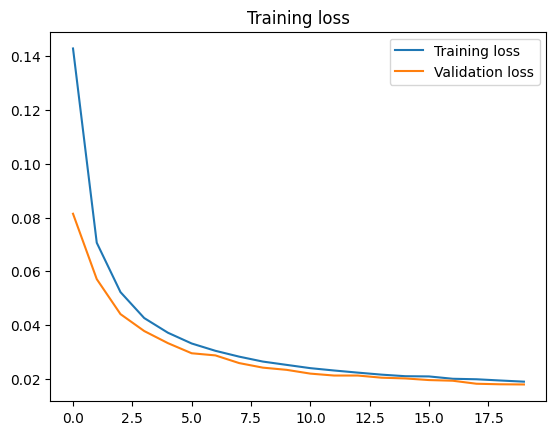

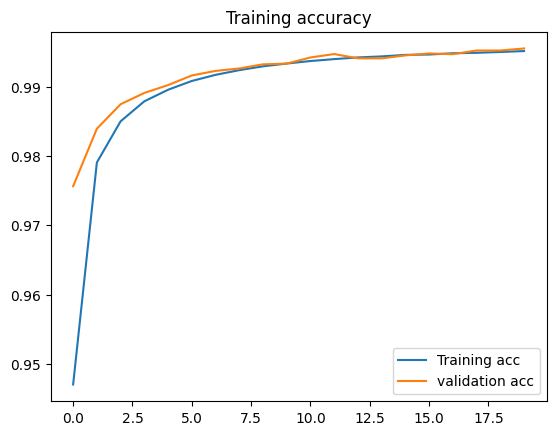

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(hist_2)

In [ ]:
test_model(model_2,X_test,y_test)

43160/43160 [==============================] - 98s 2ms/step - loss: 0.0177 - accuracy: 0.9956


(0.017692774534225464, 0.995570182800293)